In [1]:
import jax.numpy as jnp
import jax.random as jr
from jax.config import config
import re
import distrax
import pandas as pd
import numpy as np
from glob import glob 
import matplotlib.pyplot as plt
import seaborn as sns
import ot
from dataclasses import dataclass
from ensembles import ProcessModel, ModelCollection, LogLikelihoodWeight, Barycentre
from ensembles.plotters import get_style_cycler, cmap, _unique_legend
from ensembles.weights import InverseSquareWeight, UniformWeight
from ensembles.ensemble_scheme import WeightedModelMean
from ensembles.ensemble_scheme import MultiModelMean
%matplotlib inline

In [2]:
# Enable Floa64 - this is crucial for more stable matrix inversions.
config.update("jax_enable_x64", True)

key = jr.PRNGKey(123)

In [3]:
%load_ext autoreload
%autoreload 2

## Loading a plotting models and observations

Read all the model files in. Each model file is a csv where each column is a realisation from that model.

In [30]:
hist_model_files = dict()
for model_file in sorted(glob('data/gmst/historical/*csv')):
    model_name = '_'.join(model_file.split("/")[-1].split('_')[1:3])
    hist_model_files[model_name] = model_file

ssp_model_files = dict()
for model_file in sorted(glob('data/gmst/ssp370/*csv')):
    model_name = '_'.join(model_file.split("/")[-1].split('_')[1:3])
    ssp_model_files[model_name] = model_file



Find the overlap in models, they need to exist both in the historical and the ssp

In [31]:
model_overlap = np.intersect1d(list(hist_model_files.keys()), list(ssp_model_files.keys())).tolist()
print(model_overlap)

['CCCma_CanESM5', 'CNRM-CERFACS_CNRM-CM6-1', 'INM_INM-CM5-0', 'IPSL_IPSL-CM6A-LR', 'MIROC_MIROC6', 'MOHC_UKESM1-0-LL', 'MPI-M_MPI-ESM1-2-LR']


In [32]:
hist_model_files = {k:hist_model_files[k] for k in hist_model_files if k in model_overlap}
ssp_model_files = {k:ssp_model_files[k] for k in ssp_model_files if k in model_overlap}

We read in a set of observations and put this into a $\texttt{ProcessModel}$ object that stores the data of all the observational realisations

In [33]:
obs_df = pd.read_csv("data/obs/GMST_OBS.csv", index_col="time")#.iloc[:, :10]
observations = ProcessModel(obs_df, model_name='Observations')

Here, we load in all the historical model data (again into seperate $\texttt{ProcessModel}$ data classes). We then find the anomally of each model such that we can compare the model realisations directly with the observations (these come as an anomally). We also store the climatology of each model (relative to 1961-1990) so we can anomalise the forecast models later

In [34]:
hist_anom_models = []
hist_models = []
climatology_dict = dict()

for mn, mf in hist_model_files.items():
    # Read in model data into a ProcessModel datatype
    df = pd.read_csv(mf, index_col='time').drop('Unnamed: 0', axis=1)
    model_data = ProcessModel(df, mn)
    hist_models.append(model_data)

    # Find the anomally of that data
    anomaly_model = model_data.calculate_anomaly()
    hist_anom_models.append(anomaly_model)
    climatology_dict[mn] = anomaly_model.climatology

Here, we load in all the forecast model data (again into seperate $\texttt{ProcessModel}$ data classes). We then find the anomally of each model using the climatology we saved from the historical models.

In [35]:
ssp_anom_models = []
ssp_models = []

for mn, mf in ssp_model_files.items():
    # Read in model data into a ProcessModel datatype
    df = pd.read_csv(mf, index_col='time').drop('Unnamed: 0', axis=1)
    model_data = ProcessModel(df, mn)
    ssp_models.append(model_data)

    # Find the anomally of that data
    anomaly_model = model_data.calculate_anomaly(climatology=climatology_dict[mn])
    ssp_anom_models.append(anomaly_model)

We store the anomalised and non-anomalised ensemble model output in a $\texttt{ModelCollection}$ data class which contains all the ensemble data as well as providing plotting functionality

In [36]:
hist_anom_models = ModelCollection(hist_anom_models)
hist_models = ModelCollection(hist_models)

ssp_anom_models = ModelCollection(ssp_anom_models)
ssp_models = ModelCollection(ssp_models)

We can look at all the models (anomalised)

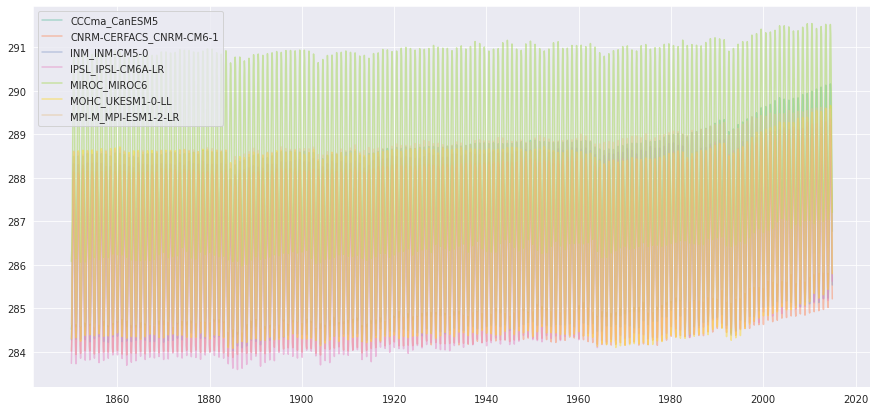

In [37]:
hist_models.plot_all()

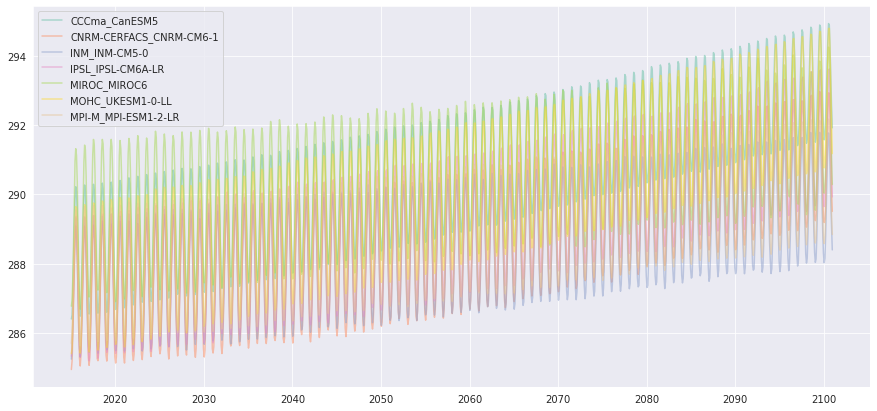

In [38]:
ssp_models.plot_all()

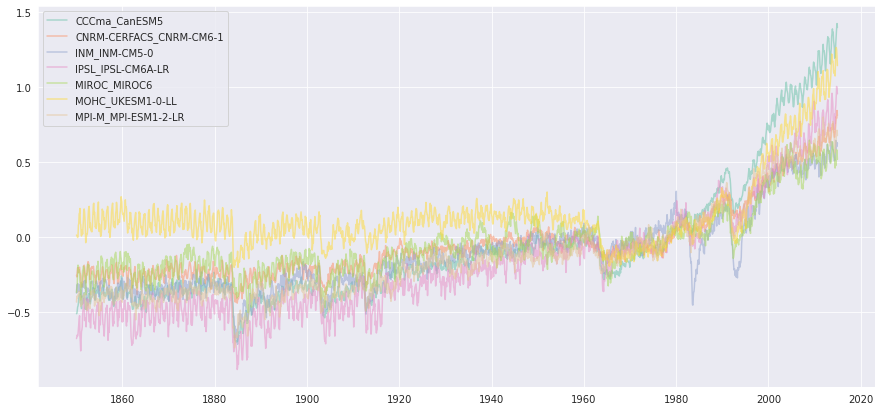

In [39]:
hist_anom_models.plot_all()

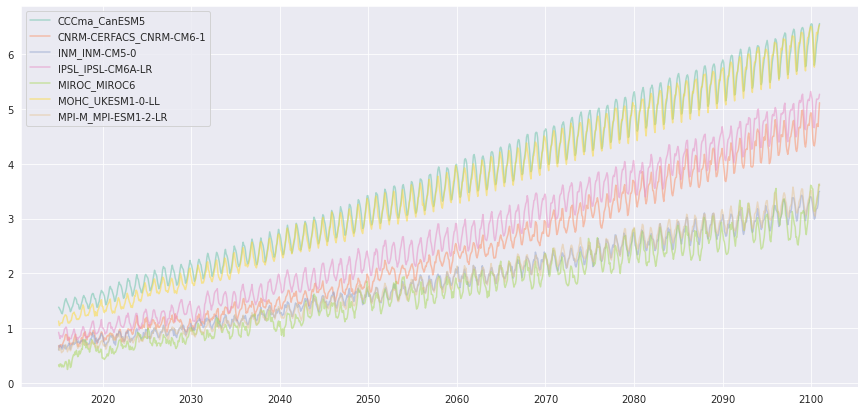

In [40]:
ssp_anom_models.plot_all()

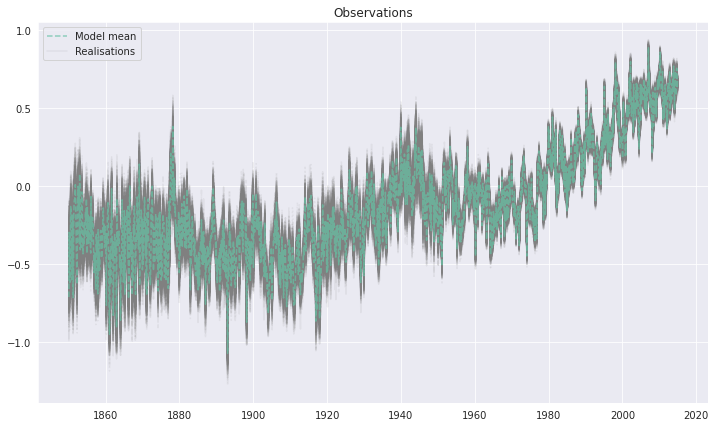

In [41]:
observations.plot()

or plot the models seperately with their individual realisations and means

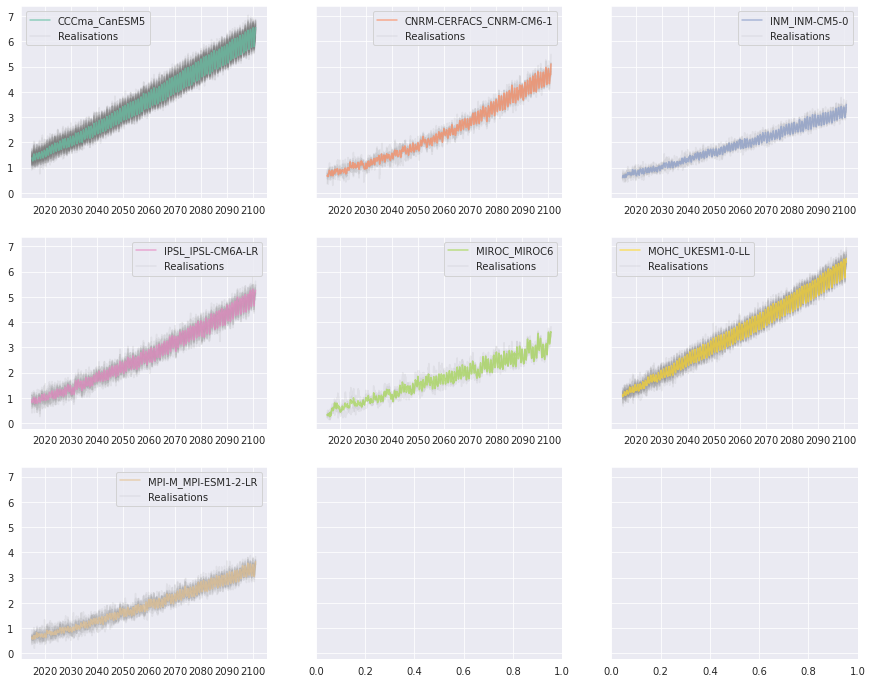

In [42]:
ssp_anom_models.plot_grid()

## Looking at weights

Now we can weight the models on how well each historical model distribution matches the realisations. This we do here by calculating the log-likelihood between the historical model pdf and the observational realisations.

In [43]:
mse_weights = InverseSquareWeight()(hist_anom_models, observations)
uniform_weights = UniformWeight()(hist_anom_models, observations)
ll_weights, lls = LogLikelihoodWeight()(hist_anom_models, observations, return_lls=True)

100%|██████████| 200/200 [00:28<00:00,  7.04it/s]


Are the log-likelihoods sensible? We look at prescaled values becuase this means the LLs are independent of all other models

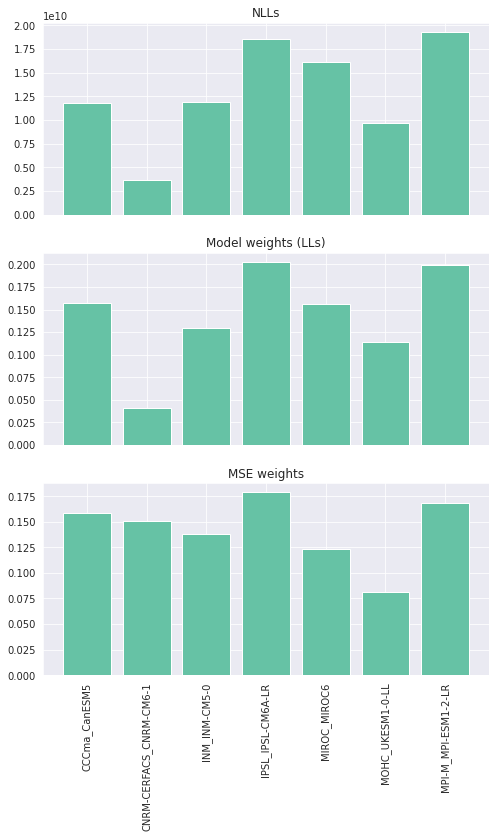

In [44]:
model_names = model_overlap

fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(8, 12))
axes[0].bar(model_names, -jnp.mean(lls, axis=0), color=cmap()[0])
axes[0].set_title('NLLs')

axes[1].bar(model_names, jnp.mean(ll_weights, axis=0), color=cmap()[0])
axes[1].set_title('Model weights (LLs)')

axes[2].bar(model_names, jnp.mean(mse_weights, axis=0), color=cmap()[0])
axes[2].set_title('MSE weights')
axes[2].tick_params(axis='x', labelrotation=90)
plt.show()

Well this is interesting. The weights you get from the loglikelihood (middle panel) are very different and fairly uncorrelated to those weights you would derive using a typical inverse square weighting between realisation mean and observational mean.

What about weights in time? Firstly seasonal, then for all time.

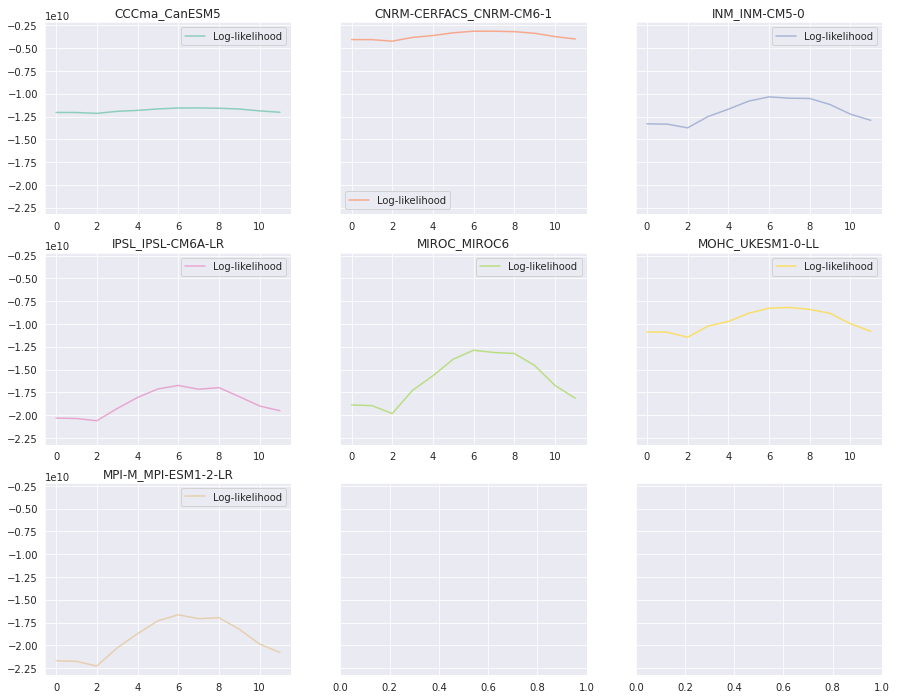

In [45]:
style_cycler = get_style_cycler()
fig, axes = plt.subplots(
    figsize=(15, 4 * np.ceil(hist_models.number_of_models/3)),
    nrows=round(np.ceil(hist_models.number_of_models/3)),
    ncols=3,
    sharey=True)
for weight, ax, kwargs, model_name in zip(lls.T, axes.ravel(), style_cycler, hist_models.model_names):
    x = np.arange(12)
    seas_weight = np.mean(weight.reshape(-1, 12), axis=0)
    ax.set_title(model_name)
    ax.plot(x, seas_weight, alpha=0.7, label='Log-likelihood', **kwargs)
    ax.legend(loc='best')
fig.show()

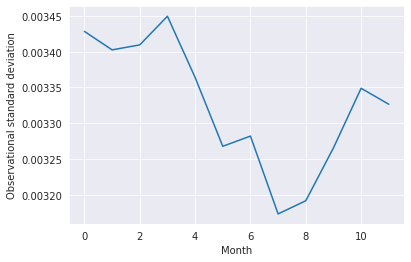

In [46]:
plt.plot(np.arange(12), np.mean(observations.temporal_covariance.diagonal().reshape(-1, 12), axis=0))
plt.xlabel('Month')
plt.ylabel('Observational standard deviation')
plt.show()

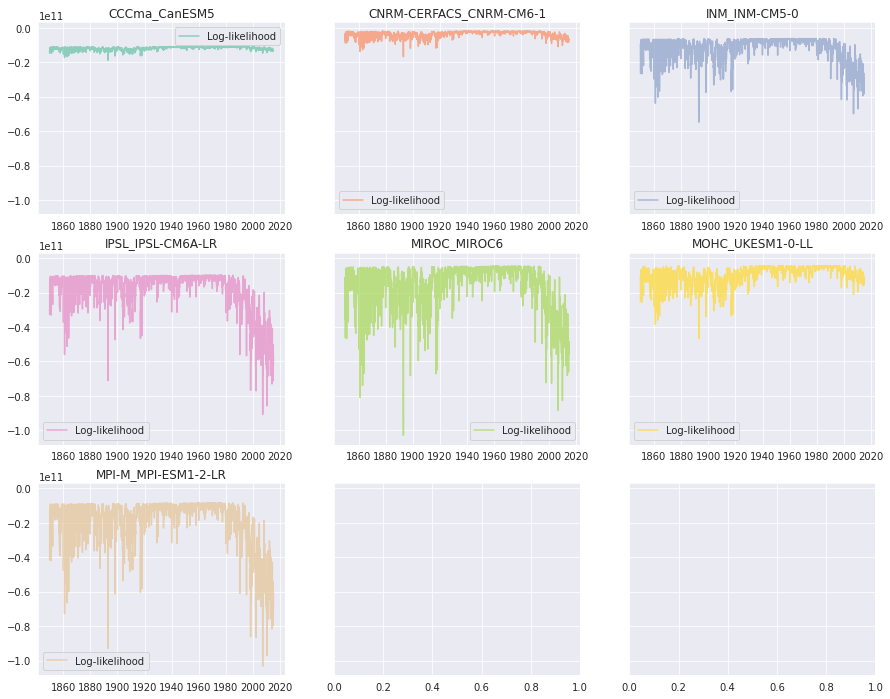

In [47]:
style_cycler = get_style_cycler()
fig, axes = plt.subplots(
    figsize=(15, 4 * np.ceil(hist_models.number_of_models/3)),
    nrows=round(np.ceil(hist_models.number_of_models/3)),
    ncols=3,
    sharey=True)
for weight, ax, kwargs, model_name in zip(lls.T, axes.ravel(), style_cycler, hist_models.model_names):
    x = observations.time
    ax.set_title(model_name)
    ax.plot(x, weight, alpha=0.7, label='Log-likelihood', **kwargs)
    ax.legend(loc='best')
fig.show()

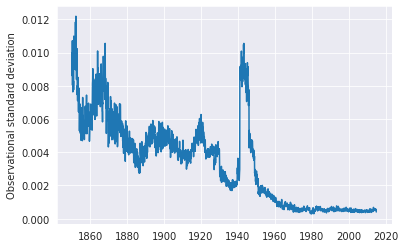

In [48]:
plt.plot(observations.time, observations.temporal_covariance.diagonal())
plt.ylabel('Observational standard deviation')
plt.show()

The above temoral loglikelihoods are interesting as they all get lower towards 2020, which means the models are becoming less good fits to the observations. I guess that this is actually an artifact of the data, because the observations should become much more certain towards the end of the 20th century, whilst the model distributions are very narrow as they are GMST. This can be seen in the plot below where the standard deviation of the observations becomes much lower in the latter half of the 20th century.  

Seasonally, all models have a higher log-likelihood in summer, so they are a better fit to the observations. There is very little dependence on observational standard deviation from a seasonal influence unlike above.

## Barycentres

From these model weights we can compute a weighted barycentre which will be our estimate of the true posterior. We compute the barycentre using the non-anomalised models to show us the absolute temperature, rather than the temperature realitive to a climatology.

In [49]:
hist_mmm_dist = MultiModelMean()(hist_anom_models)
hist_wm_dist = WeightedModelMean()(hist_anom_models, weights=jnp.mean(mse_weights, axis=0))
hist_weighted_bary = Barycentre()(hist_anom_models, weights=np.asarray(ll_weights))
hist_unweighted_bary = Barycentre()(hist_anom_models, weights=np.ones_like(np.asarray(ll_weights)) * 1/hist_anom_models.number_of_models)

100%|██████████| 1980/1980 [00:58<00:00, 33.85it/s]


TODO: These currently return arrays of distributions, would be way easier if they returned a MVN

In [50]:
ssp_mmm_dist = MultiModelMean()(ssp_anom_models)
ssp_wm_dist = WeightedModelMean()(ssp_anom_models, weights=jnp.mean(mse_weights, axis=0))
ssp_weighted_bary = Barycentre()(ssp_anom_models, weights=np.asarray(ll_weights))
ssp_unweighted_bary = Barycentre()(ssp_anom_models, weights=np.ones_like(np.asarray(ll_weights)) * 1/ssp_anom_models.number_of_models)

100%|██████████| 1032/1032 [00:20<00:00, 51.44it/s]


Plot the projection

In [57]:
np.asarray([dist.mean() for dist in hist_mmm_dist])

array([-0.37772267, -0.36994657, -0.35857973, ...,  1.05043684,
        1.06603997,  1.03455723])

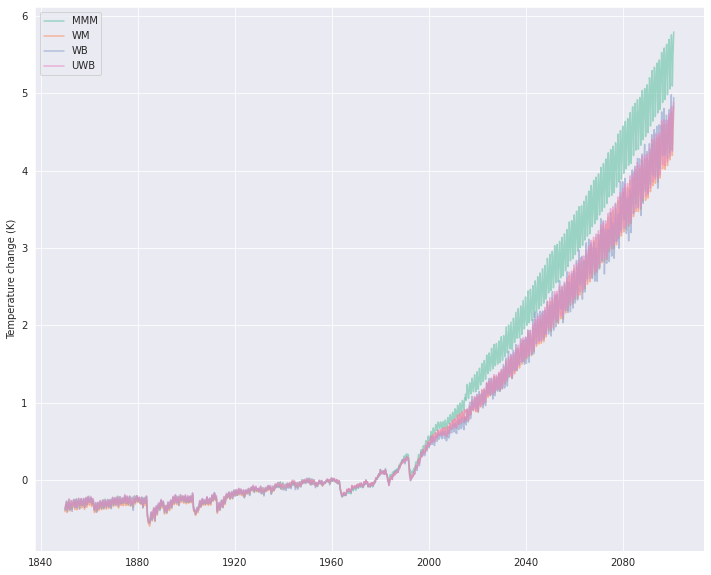

In [64]:
style_cycler = get_style_cycler()

plt.figure(figsize=(12,10))
ax = plt.gca()
ax.set_prop_cycle(get_style_cycler())
alpha = 0.6

# Plot historic things
plt.plot(hist_models.time, np.asarray([dist.mean() for dist in hist_mmm_dist]), label='MMM', alpha=alpha)
plt.plot(hist_models.time, np.asarray([dist.mean() for dist in hist_wm_dist]), label='WM', alpha=alpha)
plt.plot(hist_models.time, np.asarray([dist.mean() for dist in hist_weighted_bary]), label='WB', alpha=alpha)
plt.plot(hist_models.time, np.asarray([dist.mean() for dist in hist_unweighted_bary]), label='UWB', alpha=alpha)



style_cycler = get_style_cycler()
ax.set_prop_cycle(get_style_cycler())
plt.plot(ssp_models.time, np.asarray([dist.mean() for dist in ssp_mmm_dist]), alpha=alpha)
plt.plot(ssp_models.time, np.asarray([dist.mean() for dist in ssp_wm_dist]), alpha=alpha)
plt.plot(ssp_models.time, np.asarray([dist.mean() for dist in ssp_weighted_bary]), alpha=alpha)
plt.plot(ssp_models.time, np.asarray([dist.mean() for dist in ssp_unweighted_bary]), alpha=alpha)

plt.ylabel('Temperature change (K)')
plt.legend()
plt.show()

What about uncertainty in the projections

In [67]:
hist_mmm_dist[0].variance()

DeviceArray(0.0753395, dtype=float64)

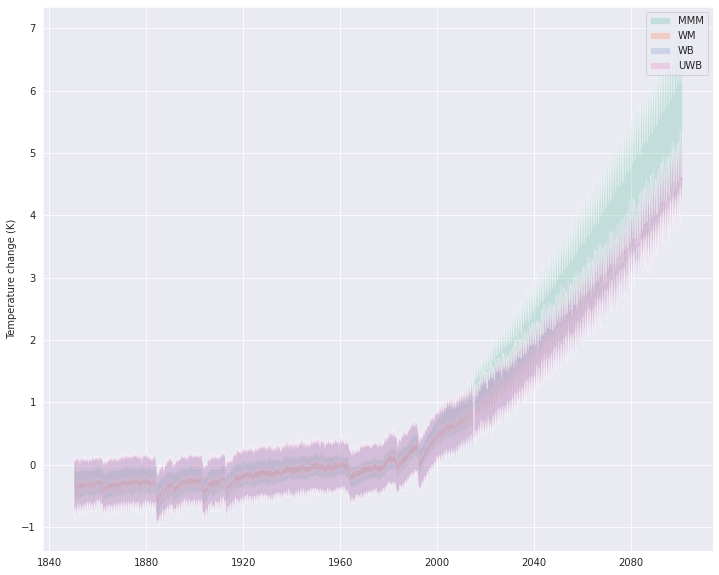

In [78]:
style_cycler = get_style_cycler()

plt.figure(figsize=(12,10))
ax = plt.gca()
ax.set_prop_cycle(get_style_cycler())
alpha = 0.3

# Plot historic things
def add_mean_std(x, dists, ax, label=None, **kwargs):
    mean = np.asarray([dist.mean() for dist in dists])
    std = np.asarray([jnp.sqrt(dist.variance()) for dist in dists])
    ax.fill_between(x, mean - std, mean + std, label=label, alpha=alpha, **kwargs)

add_mean_std(hist_models.time, hist_mmm_dist, ax, label='MMM')
add_mean_std(hist_models.time, hist_wm_dist, ax, label='WM')
add_mean_std(hist_models.time, hist_weighted_bary, ax, label='WB')
add_mean_std(hist_models.time, hist_unweighted_bary, ax, label='UWB')


style_cycler = get_style_cycler()
ax.set_prop_cycle(get_style_cycler())
add_mean_std(ssp_models.time, ssp_mmm_dist, ax)
add_mean_std(ssp_models.time, ssp_wm_dist, ax)
add_mean_std(ssp_models.time, ssp_weighted_bary, ax)
add_mean_std(ssp_models.time, ssp_unweighted_bary, ax)

plt.ylabel('Temperature change (K)')
plt.legend()
plt.show()

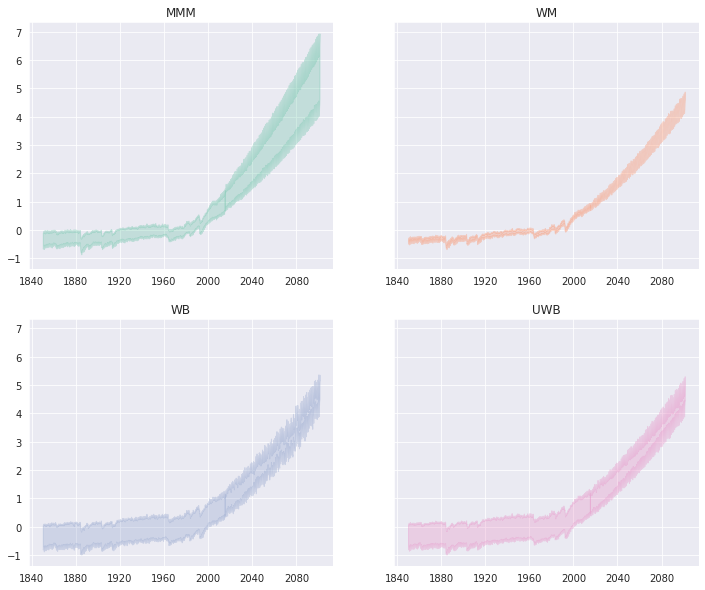

In [83]:
style_cycler = get_style_cycler()()
fig, axes = plt.subplots(
    figsize=(12, 10),
    nrows=2,
    ncols=2,
    sharey=True)

axes = axes.ravel()

ax = axes[0]
style = next(style_cycler)
add_mean_std(hist_models.time, hist_mmm_dist, ax, **style)
add_mean_std(ssp_models.time, ssp_mmm_dist, ax, **style)
ax.set_title('MMM')
ax = axes[1]
style = next(style_cycler)
add_mean_std(hist_models.time, hist_wm_dist, ax, **style)
add_mean_std(ssp_models.time, ssp_wm_dist, ax, **style)
ax.set_title('WM')
ax = axes[2]
style = next(style_cycler)
add_mean_std(hist_models.time, hist_weighted_bary, ax, **style)
add_mean_std(ssp_models.time, ssp_weighted_bary, ax, **style)
ax.set_title('WB')
ax = axes[3]
style = next(style_cycler)
add_mean_std(hist_models.time, hist_unweighted_bary, ax, **style)
add_mean_std(ssp_models.time, ssp_unweighted_bary, ax, **style)
ax.set_title('UWB')

fig.show()

What do these distributions look like?

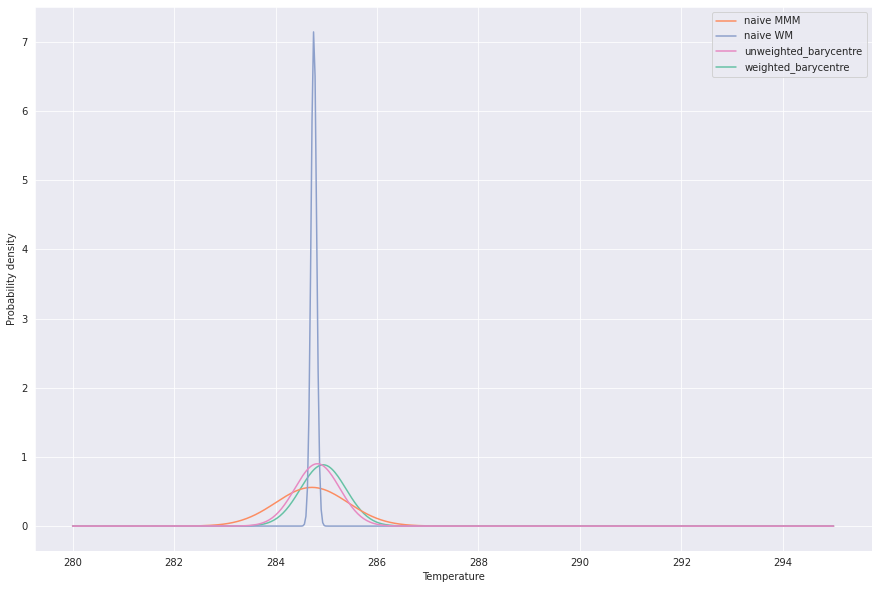

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes()
time_idx = 0
eval_x = np.linspace(280, 295, 500)

# Plot models
for i, model in enumerate(models):
    model_dist = model.as_multivariate_gaussian
    model_mean = model_dist.mean()[time_idx]
    model_std = jnp.sqrt(model_dist.variance()[time_idx])
    model_pdf = distrax.Normal(model_mean, model_std).prob(eval_x)
    ax.plot(eval_x, model_pdf, color='gray', label='model', alpha=float(ll_weights[time_idx, i]))

ax.set_prop_cycle(get_style_cycler())

# Plot weighted barycentre
ax.plot(eval_x, weighted_bary[time_idx].prob(eval_x), label='weighted_barycentre')

# Plot MMM
ax.plot(eval_x, mmm_dist[time_idx].prob(eval_x), label='naive MMM')

# Plot WM
ax.plot(eval_x, wm_dist[time_idx].prob(eval_x), label='naive WM')

# Plot unweighted Barycentre
ax.plot(eval_x, unweighted_bary[time_idx].prob(eval_x), label='unweighted_barycentre')

ax.set_xlabel('Temperature')
ax.set_ylabel('Probability density')

plt.legend()
ax = _unique_legend(ax)

plt.show()


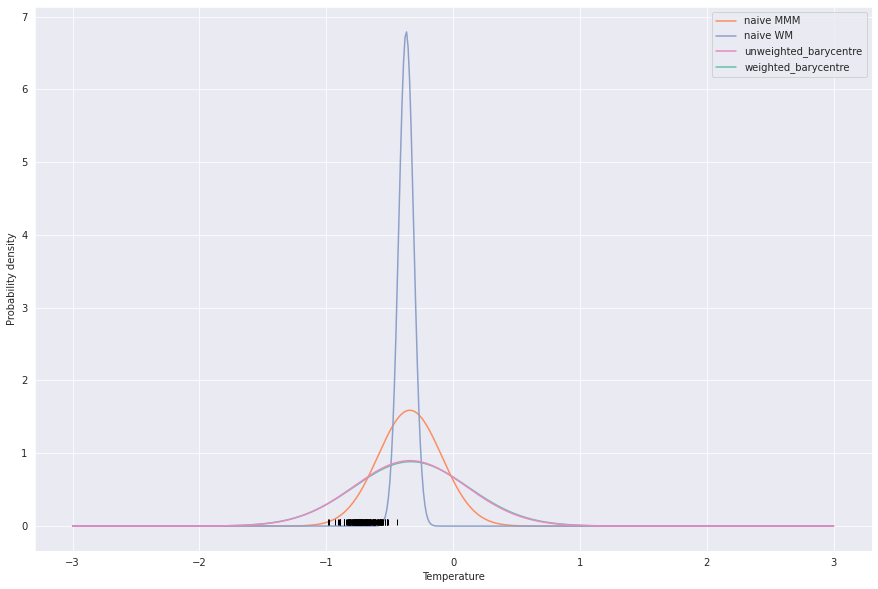

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes()
time_idx = 0
eval_x = np.linspace(-3, 3, 500)

# Plot models
for model in anom_models:
    model_dist = model.as_multivariate_gaussian
    model_mean = model_dist.mean()[time_idx]
    model_std = jnp.sqrt(model_dist.variance()[time_idx])
    model_pdf = distrax.Normal(model_mean, model_std).prob(eval_x)
    ax.plot(eval_x, model_pdf, color='gray', label='model', alpha=float(ll_weights[time_idx, i]))

ax.set_prop_cycle(get_style_cycler())

# Plot weighted barycentre
ax.plot(eval_x, anom_weighted_bary[time_idx].prob(eval_x), label='weighted_barycentre')

# Plot MMM
ax.plot(eval_x, anom_mmm_dist[time_idx].prob(eval_x), label='naive MMM')

# Plot WM
ax.plot(eval_x, anom_wm_dist[time_idx].prob(eval_x), label='naive WM')

# Plot unweighted Barycentre
ax.plot(eval_x, anom_unweighted_bary[time_idx].prob(eval_x), label='unweighted_barycentre')

# Plot observations
ax.plot(observations.model_data.values[time_idx, :], [0.05] * observations.n_realisations, 'k|')

ax.set_xlabel('Temperature')
ax.set_ylabel('Probability density')

plt.legend()
ax = _unique_legend(ax)

plt.show()


## Making projections

How do we best push weights forward in time?
- Assume flat weight
- Assume seasonal weights
- Model weights
- Exponentially decaying weights

Load in forecast realisations

In [ ]:
model_files = glob('data/gmst/*csv')

This above plot is confusing.

- Why are the barycentres so similar?  
- Why is the barycentre wider than any of the distributions?  
- Why is the barycentre in the anomally space so broad?

In [ ]:
ll_weights[time_idx]

DeviceArray([0.10824136, 0.06142582, 0.06918815, 0.08895786, 0.05600182,
             0.09487085, 0.06282835, 0.0958951 , 0.0616758 , 0.04943513,
             0.0736388 , 0.09842478, 0.07941617], dtype=float64)